In [1]:
import FinanceDataReader as fdr
import talib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import optuna

c:\Users\User\AppData\Local\anaconda3\envs\jmc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 종목 및 구간 설정
tickers = 'UPS'
start_date = '2014-01-01'
end_date = '2024-07-02'

data = fdr.DataReader(tickers, start=start_date, end=end_date)

# 컬럼 선택
selected_columns = ['Open', 'High', 'Low', 'Adj Close', 'Volume']
UPS = data[selected_columns]

# 수정 종가 컬럼 종가로 이름 변경
UPS = UPS.rename(columns={'Adj Close': 'Close'})

In [3]:
UPS['label'] = UPS['Close'].shift(-1)
UPS['label'] = UPS.apply(lambda row: 'up' if row['label'] > row['Close'] else 'down', axis=1)

UPS = UPS[:-1]
UPS

,Open,High,Low,Close,Volume,label
Date,,,,,,
2014-01-02,104.629997,104.910004,102.820000,74.292152,2799700,down
2014-01-03,103.480003,103.940002,103.050003,74.126778,3719600,down
2014-01-06,103.529999,103.669998,101.230003,73.163239,3884800,up
2014-01-07,101.839996,102.889999,101.800003,73.400558,3385700,down
2014-01-08,102.120003,102.279999,101.410004,73.343033,3024400,up
...,...,...,...,...,...,...
2024-06-24,137.800003,139.639999,137.139999,138.600006,3695900,down
2024-06-25,138.039993,138.039993,134.050003,134.360001,4893700,up
2024-06-26,136.479996,138.949997,135.100006,138.149994,6104300,down


In [5]:
# 클래스 균형 확인
UPS["label"].value_counts()

label
up      1363
down    1277
Name: count, dtype: int64

In [6]:
close = UPS['Close']
volume = UPS["Volume"]

In [7]:
df = UPS.copy()

df.loc[:, 'cmo'] = talib.CMO(close, timeperiod=14)
df.loc[:, 'ht_dcperiod'] = talib.HT_DCPERIOD(close)
df.loc[:, 'ht_dcphase'] = talib.HT_DCPHASE(close)
sine, leadsine = talib.HT_SINE(close)
df.loc[:, 'sine'] = sine
df.loc[:, 'leadsine'] = leadsine
df.loc[:, 'ht_trendmode'] = talib.HT_TRENDMODE(close)
df.loc[:, 'ppo'] = talib.PPO(close, fastperiod=12, slowperiod=26)
df.loc[:, 'roc'] = talib.ROC(close, timeperiod=10)
df.loc[:, 'rsi'] = talib.RSI(close, timeperiod=14)
fastk, fastd = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3)
df.loc[:, 'fastk'] = fastk
df.loc[:, 'fastd'] = fastd
df.loc[:, 'trix'] = talib.TRIX(close, timeperiod=30)

In [8]:
# 특정 날짜 이전의 행 삭제
cutoff_date = pd.Timestamp('2014-06-02')
df = df[df.index >= cutoff_date]
df

,Open,High,Low,Close,Volume,label,cmo,ht_dcperiod,ht_dcphase,sine,leadsine,ht_trendmode,ppo,roc,rsi,fastk,fastd,trix
Date,,,,,,,,,,,,,,,,,,
2014-06-02,104.129997,104.300003,103.599998,75.867340,2914100,down,42.553987,20.149763,199.259571,-0.329848,-0.900771,1,2.089742,2.713879,71.276993,73.475123,79.922566,0.080975
2014-06-03,103.910004,104.160004,103.070000,75.393547,2319200,down,31.328843,20.817360,198.548099,-0.318101,-0.895309,1,2.075437,2.012062,65.664421,0.000000,46.589233,0.085913
2014-06-04,103.389999,103.500000,102.599998,75.058220,2822100,up,23.893102,21.329146,197.310430,-0.297549,-0.885478,1,2.002397,2.427134,61.946551,0.000000,24.491708,0.090458
2014-06-05,103.330002,103.639999,102.970001,75.532013,2514900,down,29.929836,21.606433,199.771421,-0.338269,-0.904615,1,1.943469,1.847825,64.964918,32.349668,10.783223,0.094781
2014-06-06,103.739998,103.849998,103.430000,75.510162,2103700,down,29.419981,21.467164,199.769055,-0.338230,-0.904597,1,1.973182,1.898491,64.709991,29.617455,20.655708,0.098833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-24,137.800003,139.639999,137.139999,138.600006,3695900,down,-1.543758,20.444870,11.691202,0.202637,0.835723,1,-1.669362,0.697477,49.228121,100.000000,97.627186,-0.122036
2024-06-25,138.039993,138.039993,134.050003,134.360001,4893700,up,-21.212632,20.482136,1.083987,0.018918,0.720357,1,-1.443853,-2.411383,39.393684,34.444407,75.775322,-0.125094
2024-06-26,136.479996,138.949997,135.100006,138.149994,6104300,down,-1.662347,20.417015,6.611972,0.115145,0.783823,1,-1.108224,0.582445,49.168827,99.397073,77.947160,-0.127420


In [9]:
# 전처리
df = df.copy()
df['label'] = df['label'].map({'up': 1, 'down': 0})
df.index = pd.to_datetime(df.index)
idx = pd.Timestamp('2023-01-01')
train_data = df[df.index < idx]
test_data = df[df.index >= idx]

# 수익률 계산을 위한 데이터프레임 준비
calcu_df = df.copy()
calcu_df = calcu_df[['Open','Close', 'label']]
calcu_df = calcu_df[calcu_df.index >= idx]
calcu_df.head(5)

,Open,Close,label
Date,,,
2023-01-03,174.270004,164.871567,1
2023-01-04,176.449997,166.592911,0
2023-01-05,174.880005,163.517075,1
2023-01-06,175.630005,168.323639,1
2023-01-09,179.220001,170.900925,0


### logistic regression

In [10]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# 모델 선언
lr = LogisticRegression(random_state=123)
# 모델 학습
lr.fit(train_x_scaled, train_y)
# train, test 추정
train_pred = lr.predict(train_x_scaled)
y_pred = lr.predict(test_x_scaled)
# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)
# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.5409
test Accuracy: 0.4866


In [20]:
# 수익률 계산용 데이터프레임에 예측값 추가
calcu_df['lr_predict'] = y_pred
calcu_df.head(5)
calcu_df['lr_predict'].value_counts()

lr_predict
1    224
0    150
Name: count, dtype: int64

### KNN

In [21]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# 모델 선언
knn = KNeighborsClassifier()

# 모델 학습
knn.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = knn.predict(train_x_scaled)
y_pred = knn.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.6861
test Accuracy: 0.4492


In [22]:
# GridSearchCV를 사용하여 최적의 k 값 찾기 (전체 변수)
param_grid = {'n_neighbors': np.arange(1, 75)}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_x_scaled, train_y)

# 최적의 k 값
best_k = grid_search.best_params_['n_neighbors']
print(f"Best k value: {best_k}")

Best k value: 42


In [23]:
# 파라미터 최적화 후 KNN 모델 생성
knn_bp = KNeighborsClassifier(n_neighbors = best_k)

knn_bp.fit(train_x_scaled, train_y)

train_pred_bp = knn_bp.predict(train_x_scaled)
y_pred_bp = knn_bp.predict(test_x_scaled)

train_accuracy_bp = accuracy_score(train_y, train_pred_bp)
accuracy_bp = accuracy_score(test_y, y_pred_bp)

print(f"train Accuracy: {train_accuracy_bp:.4f}")
print(f"test Accuracy: {accuracy_bp:.4f}")

train Accuracy: 0.5576
test Accuracy: 0.4545


In [24]:
# 수익률 계산용 데이터프레임에 랜덤포레스트 예측값 추가
calcu_df['knn_predict'] = y_pred_bp
calcu_df.head(5)
calcu_df['knn_predict'].value_counts()

knn_predict
1    194
0    180
Name: count, dtype: int64

### naive baise

In [25]:
## 변수 집합
select_nb = ['ht_dcperiod', 'ht_dcphase', 'ht_trendmode', 'sine', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select_nb]
train_y = train_data['label']
test_x = test_data[select_nb]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_nb = scaler.fit_transform(train_x)
test_x_nb = scaler.transform(test_x)

# 모델 선언
nb = GaussianNB()

# 모델 학습
nb.fit(train_x_nb, train_y)

# train, test 추정
train_pred = nb.predict(train_x_nb)
y_pred = nb.predict(test_x_nb)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.5381
test Accuracy: 0.4358


In [27]:
# 수익률 계산용 데이터프레임에 랜덤포레스트 예측값 추가
calcu_df['nb_predict'] = y_pred
calcu_df.head(5)
calcu_df['nb_predict'].value_counts()

nb_predict
1    243
0    131
Name: count, dtype: int64

### random forest

In [28]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# 모델 선언
rf = RandomForestClassifier(random_state=123)

# 모델 학습
rf.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = rf.predict(train_x_scaled)
y_pred = rf.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 1.0000
test Accuracy: 0.4626


         Feature  Importance
1    ht_dcperiod    0.107067
7            roc    0.104281
11          trix    0.101072
6            ppo    0.096830
3           sine    0.092157
8            rsi    0.089798
0            cmo    0.089162
4       leadsine    0.087683
10         fastd    0.087045
2     ht_dcphase    0.083034
9          fastk    0.053688
5   ht_trendmode    0.008184


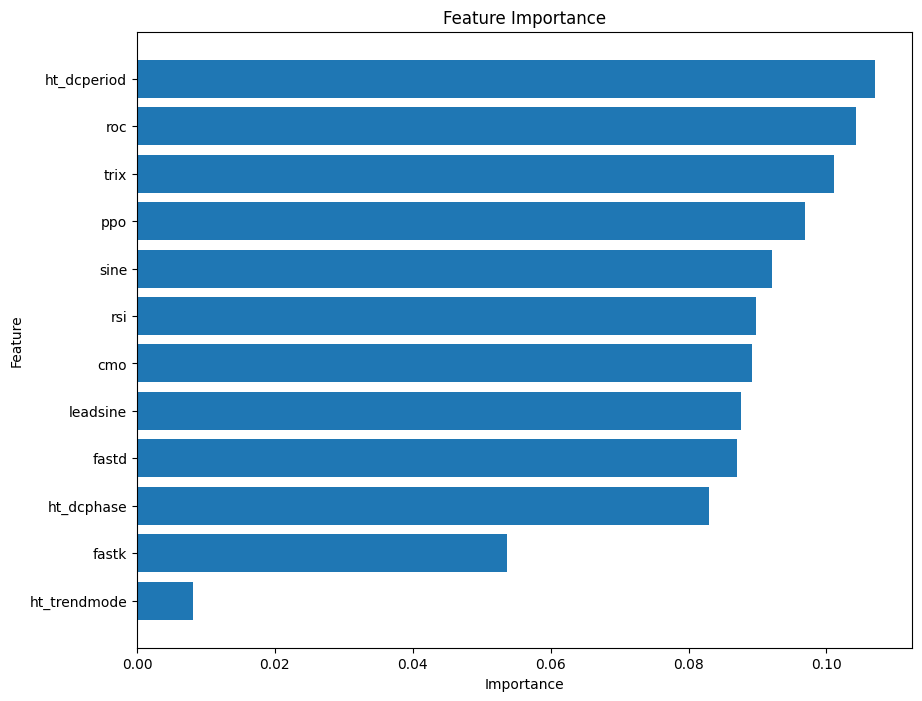

In [29]:
# 변수 중요도 계산
feature_importances = rf.feature_importances_
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [58]:
# 중요도가 0.08 이상인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0.09]['Feature']

# 선택한 변수만을 사용한 새로운 데이터 준비
train_x_rf = train_x[positive_features]
test_x_rf = test_x[positive_features]

# 데이터 스케일링
train_x_rf = scaler.fit_transform(train_x_rf)
test_x_rf = scaler.transform(test_x_rf)

# 모델 선언 및 학습
rf_important_v = RandomForestClassifier(random_state=123)
rf_important_v.fit(train_x_rf, train_y)

train_pred_important_v = rf_important_v.predict(train_x_rf)
y_pred_important_v = rf_important_v.predict(test_x_rf)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

train Accuracy: 1.0000
test Accuracy: 0.5160


In [63]:
# 변수 선택 모델 optuna

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 2, 32)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20)
    n_estimators = trial.suggest_int('n_estimators', 50, 300)
    
    model = RandomForestClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        n_estimators=n_estimators,
        random_state=123
    )
    
    scores = cross_val_score(model, train_x_rf, train_y, cv=5, scoring='accuracy')
    
    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-24 13:03:00,158] A new study created in memory with name: no-name-6c37942e-6bf3-4528-a834-47ba3b337986
[I 2024-07-24 13:03:02,895] Trial 0 finished with value: 0.5173434693353862 and parameters: {'max_depth': 32, 'min_samples_split': 9, 'min_samples_leaf': 13, 'n_estimators': 128}. Best is trial 0 with value: 0.5173434693353862.
[I 2024-07-24 13:03:06,798] Trial 1 finished with value: 0.5238153280301086 and parameters: {'max_depth': 29, 'min_samples_split': 18, 'min_samples_leaf': 12, 'n_estimators': 184}. Best is trial 1 with value: 0.5238153280301086.
[I 2024-07-24 13:03:11,070] Trial 2 finished with value: 0.5057758104524849 and parameters: {'max_depth': 26, 'min_samples_split': 19, 'min_samples_leaf': 2, 'n_estimators': 166}. Best is trial 1 with value: 0.5238153280301086.
[I 2024-07-24 13:03:13,929] Trial 3 finished with value: 0.5187312890257463 and parameters: {'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 16, 'n_estimators': 147}. Best is trial 1 with 

Best trial: 0.5270507227782055
Best parameters: {'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 18, 'n_estimators': 225}


In [65]:
best_params = study.best_params
rf_optuna = RandomForestClassifier(**best_params, random_state = 123)
rf_optuna.fit(train_x_rf, train_y)

train_pred_optuna = rf_optuna.predict(train_x_rf)
y_pred_optuna = rf_optuna.predict(test_x_rf)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

train Accuracy: 0.6607
test Accuracy: 0.4920


In [66]:
calcu_df['rf_predict'] = y_pred_optuna
calcu_df['rf_predict'].value_counts()

rf_predict
1    284
0     90
Name: count, dtype: int64

### XGB

In [67]:
## 변수 집합
select = ['cmo', 'ht_dcperiod', 'ht_dcphase', 'sine', 'leadsine', 'ht_trendmode', 'ppo', 'roc', 'rsi', 'fastk', 'fastd', 'trix']

# 독립, 종속 변수 분할
train_x = train_data[select]
train_y = train_data['label']
test_x = test_data[select]
test_y = test_data['label']

# 스케일링
scaler = StandardScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

# XGB 모델 생성
xg = xgb.XGBClassifier(random_state=123)

# 모델 학습
xg.fit(train_x_scaled, train_y)

# train, test 추정
train_pred = xg.predict(train_x_scaled)
y_pred = xg.predict(test_x_scaled)

# 정확도 계산
train_accuracy = accuracy_score(train_y, train_pred)
accuracy = accuracy_score(test_y, y_pred)

# 정확도 출력
print(f"train Accuracy: {train_accuracy:.4f}")
print(f"test Accuracy: {accuracy:.4f}")

train Accuracy: 0.9995
test Accuracy: 0.4545


         Feature  Importance
9          fastk    0.107769
10         fastd    0.096340
3           sine    0.095461
0            cmo    0.094865
6            ppo    0.093168
1    ht_dcperiod    0.092486
7            roc    0.087488
4       leadsine    0.085828
5   ht_trendmode    0.083240
2     ht_dcphase    0.082258
11          trix    0.081097
8            rsi    0.000000


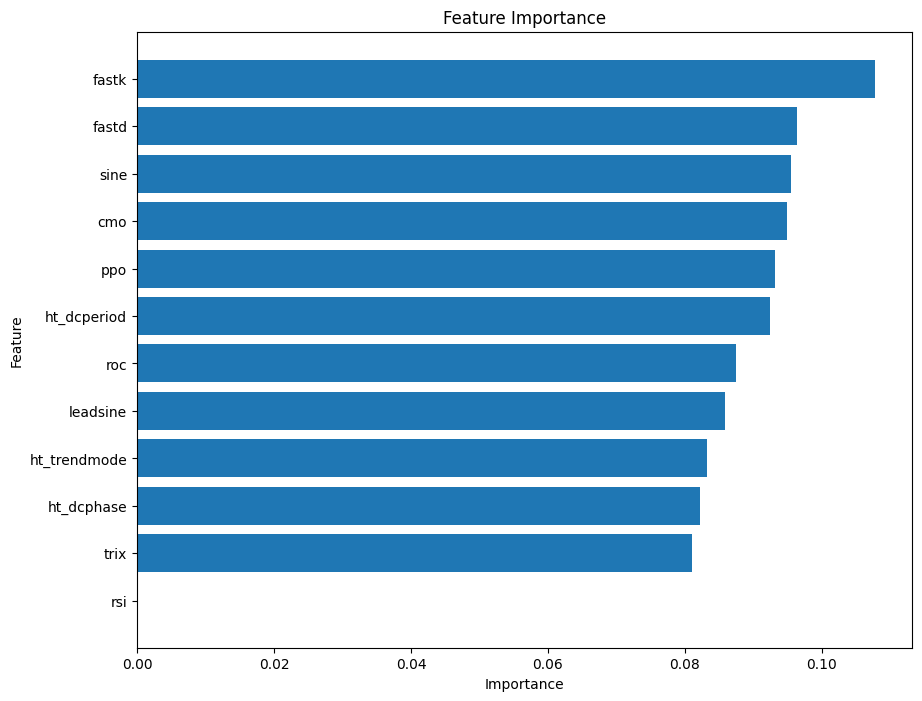

In [68]:
# 변수 중요도 계산
feature_importances = xg.feature_importances_
features = train_x.columns

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 변수 중요도 출력
print(importance_df)

# 변수 중요도 시각화
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [85]:
# 중요도가 0.09 이상인 변수만 선택
positive_features = importance_df[importance_df['Importance'] > 0.09]['Feature']

# 선택한 변수만을 사용한 새로운 데이터 준비
train_x_xg = train_x[positive_features]
test_x_xg = test_x[positive_features]

# 데이터 스케일링
train_x_xg = scaler.fit_transform(train_x_xg)
test_x_xg = scaler.transform(test_x_xg)

# 모델 선언 및 학습
xg_important_v = xgb.XGBClassifier(random_state=123)
xg_important_v.fit(train_x_xg, train_y)

train_pred_important_v = xg_important_v.predict(train_x_xg)
y_pred_important_v = xg_important_v.predict(test_x_xg)

train_accuracy_important_v = accuracy_score(train_y, train_pred_important_v)
accuracy_important_v = accuracy_score(test_y, y_pred_important_v)

print(f"train Accuracy: {train_accuracy_important_v:.4f}")
print(f"test Accuracy: {accuracy_important_v:.4f}")

train Accuracy: 0.9940
test Accuracy: 0.4626


In [92]:
# 선택 변수 모델로 optuna

def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5)
    }
    
    model = xgb.XGBClassifier(**param, random_state=123)
    scores = cross_val_score(model, train_x_xg, train_y, cv=5, scoring='accuracy')

    return scores.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

print(f"Best trial: {study.best_trial.value}")
print(f"Best parameters: {study.best_trial.params}")

[I 2024-07-24 13:06:53,801] A new study created in memory with name: no-name-9bdacf1f-2a23-42a0-972b-ca210b6dbe05
[I 2024-07-24 13:06:54,348] Trial 0 finished with value: 0.5159385424685656 and parameters: {'max_depth': 6, 'learning_rate': 0.03926703267208316, 'n_estimators': 62, 'subsample': 0.6714120540127682, 'colsample_bytree': 0.9803293405385703, 'gamma': 1.829789395165133, 'reg_alpha': 1.2294251799734783, 'reg_lambda': 0.20172161720875714}. Best is trial 0 with value: 0.5159385424685656.
[I 2024-07-24 13:06:54,713] Trial 1 finished with value: 0.5205574801129073 and parameters: {'max_depth': 7, 'learning_rate': 0.18828685370052256, 'n_estimators': 376, 'subsample': 0.8056679217233702, 'colsample_bytree': 0.5085956186227281, 'gamma': 3.048870398521121, 'reg_alpha': 4.475477517261773, 'reg_lambda': 4.433721388696543}. Best is trial 1 with value: 0.5205574801129073.
[I 2024-07-24 13:06:54,968] Trial 2 finished with value: 0.5196518689590285 and parameters: {'max_depth': 6, 'learning

Best trial: 0.5205574801129073
Best parameters: {'max_depth': 7, 'learning_rate': 0.18828685370052256, 'n_estimators': 376, 'subsample': 0.8056679217233702, 'colsample_bytree': 0.5085956186227281, 'gamma': 3.048870398521121, 'reg_alpha': 4.475477517261773, 'reg_lambda': 4.433721388696543}


In [93]:
best_params = study.best_params
xg_optuna = xgb.XGBClassifier(**best_params, random_state=123)
xg_optuna.fit(train_x_xg, train_y)

train_pred_optuna = xg_optuna.predict(train_x_xg)
y_pred_optuna = xg_optuna.predict(test_x_xg)

train_accuracy_optuna = accuracy_score(train_y, train_pred_optuna)
accuracy_optuna = accuracy_score(test_y, y_pred_optuna)

print(f"train Accuracy: {train_accuracy_optuna:.4f}")
print(f"test Accuracy: {accuracy_optuna:.4f}")

train Accuracy: 0.5650
test Accuracy: 0.4706


In [94]:
# 수익률 계산용 데이터프레임에 예측값 추가
calcu_df['xg_predict'] = y_pred_optuna
calcu_df.head(5)
calcu_df['xg_predict'].value_counts()

xg_predict
1    270
0    104
Name: count, dtype: int64

In [95]:
# calcu_df.to_csv("./models_predict_UDP.csv")

# Back test

In [113]:
calcu_df = pd.read_csv('./models_predict_UDP.csv', index_col='Date')

In [114]:
bt_df = calcu_df.copy()

bt_df.index = pd.to_datetime(bt_df.index)

bt_df

,Open,Close,label,lr_predict,knn_predict,nb_predict,rf_predict,xg_predict
Date,,,,,,,,
2023-01-03,174.270004,164.871567,1,1,1,1,1,1
2023-01-04,176.449997,166.592911,0,1,0,1,1,1
2023-01-05,174.880005,163.517075,1,1,1,1,1,1
2023-01-06,175.630005,168.323639,1,1,0,1,1,1
2023-01-09,179.220001,170.900925,0,1,1,1,1,1
...,...,...,...,...,...,...,...,...
2024-06-24,137.800003,138.600006,0,1,1,1,1,1
2024-06-25,138.039993,134.360001,1,1,1,1,1,1
2024-06-26,136.479996,138.149994,0,1,0,1,1,1


In [115]:
# 초기 자금
initial_capital = 10000.0

# 첫 번째 행의 Open 가격으로 주식 구매
first_open = bt_df.iloc[0]['Close']
shares_bought = initial_capital / first_open

# 포트폴리오 가치 계산
bt_df['Portfolio Value'] = bt_df['Close'] * shares_bought

# 최대 하락폭 (MDD) 계산
bt_df['Cumulative Max'] = bt_df['Portfolio Value'].cummax()
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100

# 최종 포트폴리오 가치
final_close = bt_df.iloc[-1]['Close']
final_portfolio_value = shares_bought * final_close

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Return: {roi:.2f}%")
print(f"MDD: {max_drawdown:.2f}%")

Final Portfolio Value: 8300.400638516403
Return: -17.00%
MDD: -29.93%


In [116]:
# 초기 자금
initial_capital = 10000.0

# 수수료율 설정
commission_rate = 0.0025

# 첫 번째 행의 Close 가격으로 주식 구매
first_open = bt_df.iloc[0]['Close']
shares_bought = initial_capital * (1 - commission_rate) / first_open

# 포트폴리오 가치 계산
bt_df['Portfolio Value'] = bt_df['Close'] * shares_bought * (1 - commission_rate)

# 최대 하락폭 (MDD) 계산
bt_df['Cumulative Max'] = bt_df['Portfolio Value'].cummax()
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100

# 최종 포트폴리오 가치
final_close = bt_df.iloc[-1]['Close']
final_portfolio_value = shares_bought * final_close * (1 - commission_rate)

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

print(f"Final Portfolio Value: {final_portfolio_value}")
print(f"Return: {roi:.2f}%")
print(f"MDD: {max_drawdown:.2f}%")


Final Portfolio Value: 8258.950512827814
Return: -17.41%
MDD: -29.93%


# voting 전략

In [117]:
calcu_df['sum'] = calcu_df.iloc[:, 3:8].sum(axis=1)
print(calcu_df['sum'])

Date
2023-01-03    5
2023-01-04    4
2023-01-05    5
2023-01-06    4
2023-01-09    5
             ..
2024-06-24    5
2024-06-25    5
2024-06-26    4
2024-06-27    5
2024-06-28    5
Name: sum, Length: 374, dtype: int64


In [118]:
calcu_df['sum'].value_counts()

sum
5    133
4     77
0     49
3     44
2     39
1     32
Name: count, dtype: int64

In [128]:
# 시그널 생성 홤수 (5일때만 buy)
def generate_sum_signal(row, prev_sum):
    if row['sum'] == 5:
        return 'holding' if prev_sum == 5 else 'buy'
    else:
        return 'clear' if prev_sum == 5 else 'no_action'

Payoff Ratio: 0.6544503715320744  
Profit Factor: 0.5855608587392246  
Final Portfolio Value: 8288.60260259202  
Return: -17.11%  
MDD: -8.98%  
Win Rate: 47%  
Number of Trades: 73  

In [129]:
# 시그널 생성 홤수 (4이상일 때 buy)
def generate_sum_signal(row, prev_sum):
    if row['sum'] >= 4:
        return 'holding' if prev_sum >= 4 else 'buy'
    else:
        return 'clear' if prev_sum >= 4 else 'no_action'

Payoff Ratio: 0.7358520006126713  
Profit Factor: 0.6925665888119259  
Final Portfolio Value: 8718.656718200555  
Return: -12.81%  
MDD: -11.69%  
Win Rate: 48%  
Number of Trades: 67  

In [121]:
# 시그널 생성 홤수 (3이상일 때 buy)
def generate_sum_signal(row, prev_sum):
    if row['sum'] >= 3:
        return 'holding' if prev_sum >= 3 else 'buy'
    else:
        return 'clear' if prev_sum >= 3 else 'no_action'

Payoff Ratio: 0.6524294887457297  
Profit Factor: 0.5520557212463867  
Final Portfolio Value: 7753.381545619218  
Return: -22.47%  
MDD: -11.69%  
Win Rate: 45%  
Number of Trades: 49  

In [130]:
# 값 초기화
calcu_df['sum_signal'] = ''
prev_sum = 0

# 시그널 생성 함수 적용
for idx, row in calcu_df.iterrows():
    calcu_df.at[idx, 'sum_signal'] = generate_sum_signal(row, prev_sum)
    prev_sum = int(row['sum'])

calcu_df.head(10)

,Open,Close,label,lr_predict,knn_predict,nb_predict,rf_predict,xg_predict,sum,sum_signal
Date,,,,,,,,,,
2023-01-03,174.270004,164.871567,1,1,1,1,1,1,5,buy
2023-01-04,176.449997,166.592911,0,1,0,1,1,1,4,holding
2023-01-05,174.880005,163.517075,1,1,1,1,1,1,5,holding
2023-01-06,175.630005,168.323639,1,1,0,1,1,1,4,holding
2023-01-09,179.220001,170.900925,0,1,1,1,1,1,5,holding
2023-01-10,181.309998,168.154312,1,1,1,1,1,1,5,holding
2023-01-11,179.529999,171.408875,1,1,1,1,1,1,5,holding
2023-01-12,183.470001,172.086090,0,1,1,1,1,1,5,holding
2023-01-13,182.179993,171.333588,0,1,1,1,1,1,5,holding


In [131]:
bt_df = calcu_df.copy()
bt_df = bt_df[['Open', 'Close', 'sum_signal']]

bt_df.index = pd.to_datetime(bt_df.index)

bt_df

,Open,Close,sum_signal
Date,,,
2023-01-03,174.270004,164.871567,buy
2023-01-04,176.449997,166.592911,holding
2023-01-05,174.880005,163.517075,holding
2023-01-06,175.630005,168.323639,holding
2023-01-09,179.220001,170.900925,holding
...,...,...,...
2024-06-24,137.800003,138.600006,holding
2024-06-25,138.039993,134.360001,holding
2024-06-26,136.479996,138.149994,holding


In [132]:
# 초기 자금
initial_capital = 10000.0
cash = initial_capital
shares = 0
num_trades = 0
wins = 0
profit_sum = 0
loss_sum = 0
win_trades = []
loss_trades = []

# 포트폴리오 가치 추적 리스트
portfolio_values = []
cumulative_max = initial_capital  # 누적 최대값 초기화

buy_price = 0

for index, row in bt_df.iterrows():
    signal = row['sum_signal']
    close_price = row['Close']
    
    if signal == 'buy' and cash > 0:
        # 매수: 현재 현금으로 최대한 많은 주식을 구매
        shares += cash / close_price
        cash = 0
        cumulative_max = shares * close_price  # 누적 최대값 초기화
        buy_price = close_price
        num_trades += 1  # 매수 시 거래 횟수 증가
    elif signal == 'clear' and shares > 0:
        # 매도: 현재 보유한 모든 주식을 판매
        cash += shares * close_price
        shares = 0
        cumulative_max = cash  # 누적 최대값 초기화
        num_trades += 1  # 매도 시 거래 횟수 증가
        
        trade_profit = close_price - buy_price
        
        if trade_profit > 0:
            wins += 1
            profit_sum += trade_profit
            win_trades.append(trade_profit)
        else:
            loss_sum += abs(trade_profit)
            loss_trades.append(trade_profit)
    
    # 현재 포트폴리오 가치 계산
    portfolio_value = cash + shares * close_price
    portfolio_values.append(portfolio_value)
    
    # 누적 최대값 갱신
    if portfolio_value > cumulative_max:
        cumulative_max = portfolio_value
    
    bt_df.loc[index, 'Cumulative Max'] = cumulative_max

# 백테스트 결과 DataFrame에 추가
bt_df['Portfolio Value'] = portfolio_values

# 최대 하락폭 (MDD) 계산
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100  # 퍼센트로 변환

# 최종 포트폴리오 가치
final_portfolio_value = portfolio_values[-1]

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# 승률 계산
win_rate = (wins / (num_trades / 2)) * 100  # 매수-매도 한 쌍을 한 거래로 간주하여 승률 계산

# Payoff Ratio 계산
average_profit_per_winning_trade = profit_sum / len(win_trades) if win_trades else 0
average_loss_per_losing_trade = loss_sum / len(loss_trades) if loss_trades else 0
payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')

# Profit Factor 계산
profit_factor = profit_sum / loss_sum if loss_sum != 0 else float('inf')

print(f"Payoff Ratio: {payoff_ratio}  ")
print(f"Profit Factor: {profit_factor}  ")
print(f"Final Portfolio Value: {final_portfolio_value}  ")
print(f"Return: {roi:.2f}%  ")
print(f"MDD: {max_drawdown:.2f}%  ")
print(f"Win Rate: {win_rate:.0f}%  ")
print(f"Number of Trades: {num_trades}  ")

Payoff Ratio: 0.7358520006126713  
Profit Factor: 0.6925665888119259  
Final Portfolio Value: 8718.656718200555  
Return: -12.81%  
MDD: -11.69%  
Win Rate: 48%  
Number of Trades: 67  


# 수수료

In [133]:
# 초기 자금
initial_capital = 10000.0
cash = initial_capital
shares = 0
num_trades = 0
wins = 0
profit_sum = 0
loss_sum = 0
win_trades = []
loss_trades = []

# 포트폴리오 가치 추적 리스트
portfolio_values = []
cumulative_max = initial_capital  # 누적 최대값 초기화

buy_price = 0

# 수수료율 설정
commission_rate = 0.0025

for index, row in bt_df.iterrows():
    signal = row['sum_signal']
    close_price = row['Close']
    
    if signal == 'buy' and cash > 0:
        # 매수: 현재 현금으로 최대한 많은 주식을 구매
        total_cost = cash * (1 - commission_rate)  # 수수료 차감
        shares_bought = total_cost / close_price
        cash -= total_cost
        shares += shares_bought
        cumulative_max = shares * close_price  # 누적 최대값 초기화
        buy_price = close_price
        num_trades += 1  # 매수 시 거래 횟수 증가
    elif signal == 'clear' and shares > 0:
        # 매도: 현재 보유한 모든 주식을 판매
        total_sale = shares * close_price * (1 - commission_rate)  # 수수료 차감
        cash += total_sale
        shares = 0
        cumulative_max = cash  # 누적 최대값 초기화
        num_trades += 1  # 매도 시 거래 횟수 증가
        
        trade_profit = (close_price - buy_price) * (1 - commission_rate)
        
        if trade_profit > 0:
            wins += 1
            profit_sum += trade_profit
            win_trades.append(trade_profit)
        else:
            loss_sum += abs(trade_profit)
            loss_trades.append(trade_profit)
    
    # 현재 포트폴리오 가치 계산
    portfolio_value = cash + shares * close_price
    portfolio_values.append(portfolio_value)
    
    # 누적 최대값 갱신
    if portfolio_value > cumulative_max:
        cumulative_max = portfolio_value
    
    bt_df.loc[index, 'Cumulative Max'] = cumulative_max

# 백테스트 결과 DataFrame에 추가
bt_df['Portfolio Value'] = portfolio_values

# 최대 하락폭 (MDD) 계산
bt_df['Drawdown'] = (bt_df['Portfolio Value'] - bt_df['Cumulative Max']) / bt_df['Cumulative Max']
max_drawdown = bt_df['Drawdown'].min() * 100  # 퍼센트로 변환

# 최종 포트폴리오 가치
final_portfolio_value = portfolio_values[-1]

# 수익률 계산
roi = ((final_portfolio_value - initial_capital) / initial_capital) * 100

# 승률 계산
win_rate = (wins / (num_trades / 2)) * 100  # 매수-매도 한 쌍을 한 거래로 간주하여 승률 계산

# Payoff Ratio 계산
average_profit_per_winning_trade = profit_sum / len(win_trades) if win_trades else 0
average_loss_per_losing_trade = loss_sum / len(loss_trades) if loss_trades else 0
payoff_ratio = average_profit_per_winning_trade / average_loss_per_losing_trade if average_loss_per_losing_trade != 0 else float('inf')

# Profit Factor 계산
profit_factor = profit_sum / loss_sum if loss_sum != 0 else float('inf')

print(f"Payoff Ratio: {payoff_ratio}  ")
print(f"Profit Factor: {profit_factor}  ")
print(f"Final Portfolio Value: {final_portfolio_value}  ")
print(f"Return: {roi:.2f}%  ")
print(f"MDD: {max_drawdown:.2f}%  ")
print(f"Win Rate: {win_rate:.0f}%  ")
print(f"Number of Trades: {num_trades}  ")

Payoff Ratio: 0.7358520006126711  
Profit Factor: 0.6925665888119258  
Final Portfolio Value: 8032.292742130309  
Return: -19.68%  
MDD: -11.66%  
Win Rate: 48%  
Number of Trades: 67  


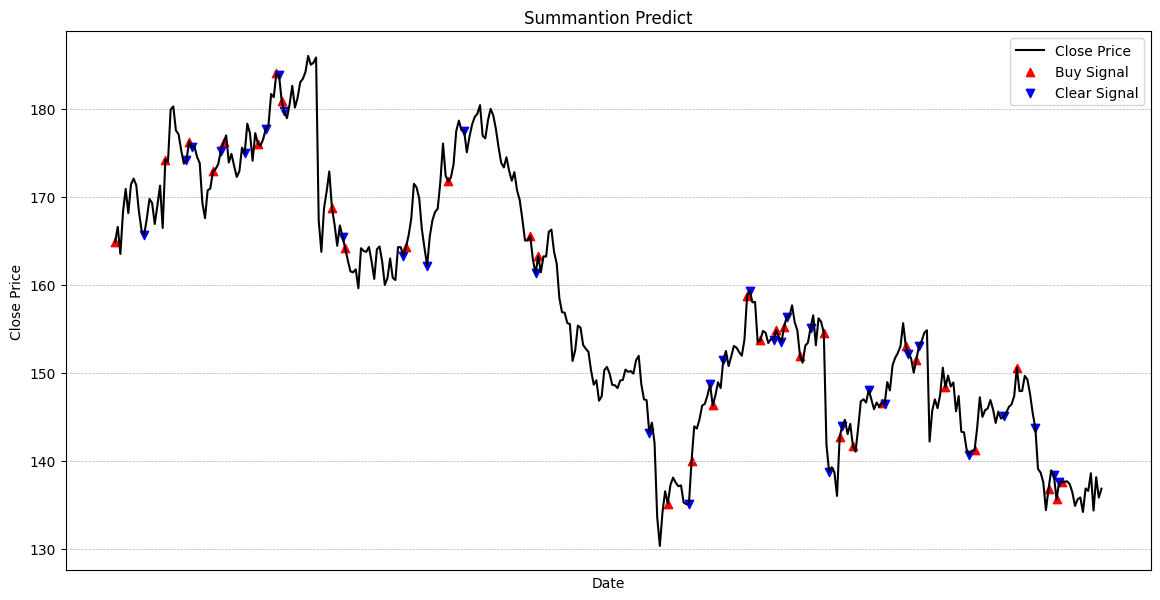

In [134]:
# Close 값 시각화
plt.figure(figsize=(14, 7))
plt.plot(calcu_df.index, calcu_df['Close'], label='Close Price', color='black')

# 'buy' 시그널 빨간색 점으로 표시
buy_signals = calcu_df[calcu_df['sum_signal'] == 'buy']
plt.scatter(buy_signals.index, buy_signals['Close'], label='Buy Signal', color='red', marker='^', alpha=1)

# 'clear' 시그널 파란색 점으로 표시
clear_signals = calcu_df[calcu_df['sum_signal'] == 'clear']
plt.scatter(clear_signals.index, clear_signals['Close'], label='Clear Signal', color='blue', marker='v', alpha=1)

# 그래프 제목과 축 레이블 설정
plt.title('Summantion Predict')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()

# 그리드 설정 - 세로선 제거
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.grid(False, which='major', axis='x')

# x축 날짜 레이블 비활성화
plt.xticks([])

plt.show()